In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [6]:
# Load dataset
df = pd.read_csv('Time series data.csv', parse_dates=['DATE'],index_col='DATE')
df.rename(columns={'IPG2211A2N': 'Time series'}, inplace=True)

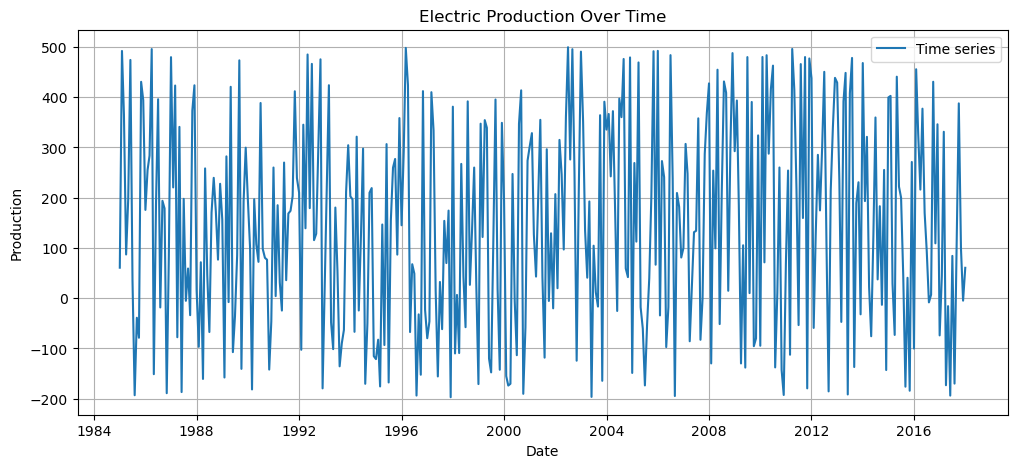

In [8]:
# Plot raw data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Time series'], label='Time series')
plt.title('Electric Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Feature Engineering: Lag, Rolling, Expanding
df['Lag_1'] = df['Time series'].shift(1)
df['Rolling_Mean_12'] = df['Time series'].rolling(window=12).mean()
df['Expanding_Mean'] = df['Time series'].expanding().mean()

In [17]:
df
# Bhai ye jo NaN values aa rahi hain rolling mean ke start me, uski reason bahut simple hai:"12 mahine ka moving average 
# lo" — lekin jab tak 12 data points na ho jaayein, tab tak wo mean calculate kar hi nahi sakta, isliye NaN deta hai.

,Electric_Production,Lag_1,Rolling_Mean_12,Expanding_Mean
DATE,,,,
1985-01-01,60.646135,NaN,NaN,60.646135
1985-02-01,491.960709,60.646135,NaN,276.303422
1985-03-01,365.295098,491.960709,NaN,305.967314
1985-04-01,86.926312,365.295098,NaN,251.207064
1985-05-01,197.215988,86.926312,NaN,240.408849
...,...,...,...,...
2017-09-01,107.093446,-170.013899,68.728677,145.156105
2017-10-01,387.643751,107.093446,65.141160,145.771556
2017-11-01,98.383775,387.643751,64.245426,145.651587


In [12]:
# Check for the stationary usinf ADF Test
def adf_test(df):
    result = adfuller(df)
    print("ADF Statistic:", result[0])
    print("p-values:", result[1])
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is not Stationary")

In [14]:
adf_test(df['Time series'])

ADF Statistic: -20.31221437561321
p-values: 0.0
Data is Stationary


In [16]:
# Differencing to remove trend and seasonality if there is seasonality
df['Electric_Production_diff'] = df['Time series'].diff().dropna()
df['Electric_Production_seasonal_diff'] = df['Time series'].diff(12).dropna()

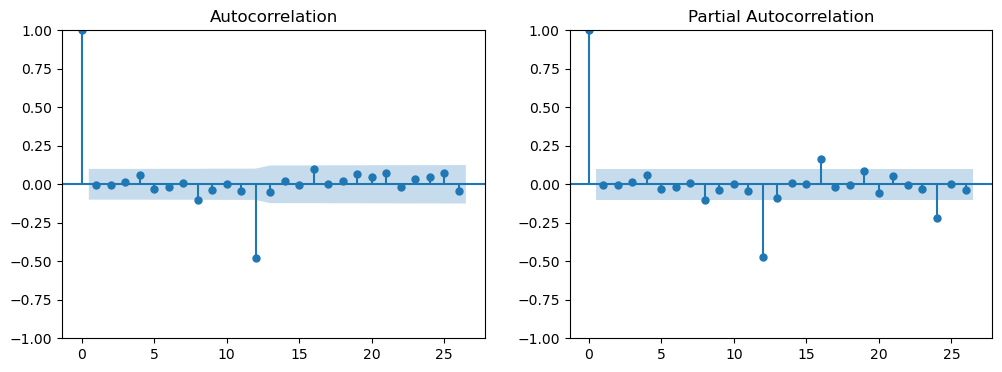

In [18]:
# plot ACF and PACF to identify parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Electric_Production_seasonal_diff'].dropna(), ax=axes[0])
plot_pacf(df['Electric_Production_seasonal_diff'].dropna(), ax=axes[1])
plt.show()

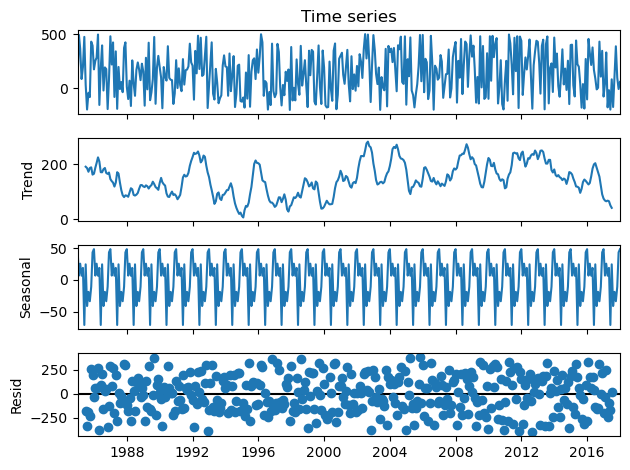

In [20]:
# Decomposition
decomposition = seasonal_decompose(df['Time series'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

In [22]:
# Differencing
# First order
df['Diff_1'] = df['Time series'].diff()
# Seasonal differencing
df['Seasonal_Diff_12'] = df['Time series'].diff(12)

In [24]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df['Time series'][0:train_size], df['Time series'][train_size:]

In [26]:
#walk forward validation
history = train.tolist()
predictions = []
for t in test:
    model = AutoReg(history, lags = 7)
    model_fit = model.fit()
    
    y_pred = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(y_pred)
    
    history.append(t)

In [28]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Walk-Forward Validation RMSE: {rmse:.4f}')

Walk-Forward Validation RMSE: 213.9548


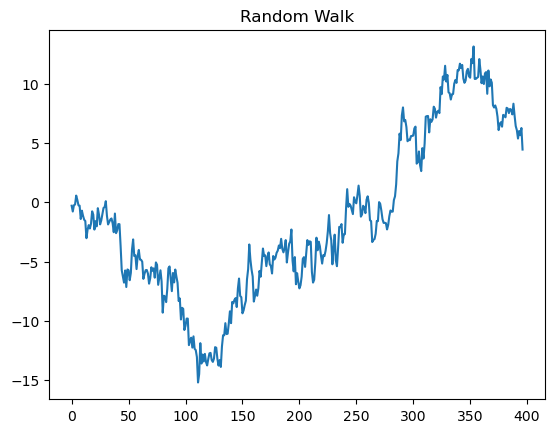

In [30]:
# Random walk
random_walk = np.random.normal(0, 1, len(df)).cumsum()
plt.plot(random_walk)
plt.title('Random Walk')
plt.show()

In [32]:
# AR model
model_ar = AutoReg(train, lags=12).fit()
predictions = model_ar.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

C:\Users\ronit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ronit\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


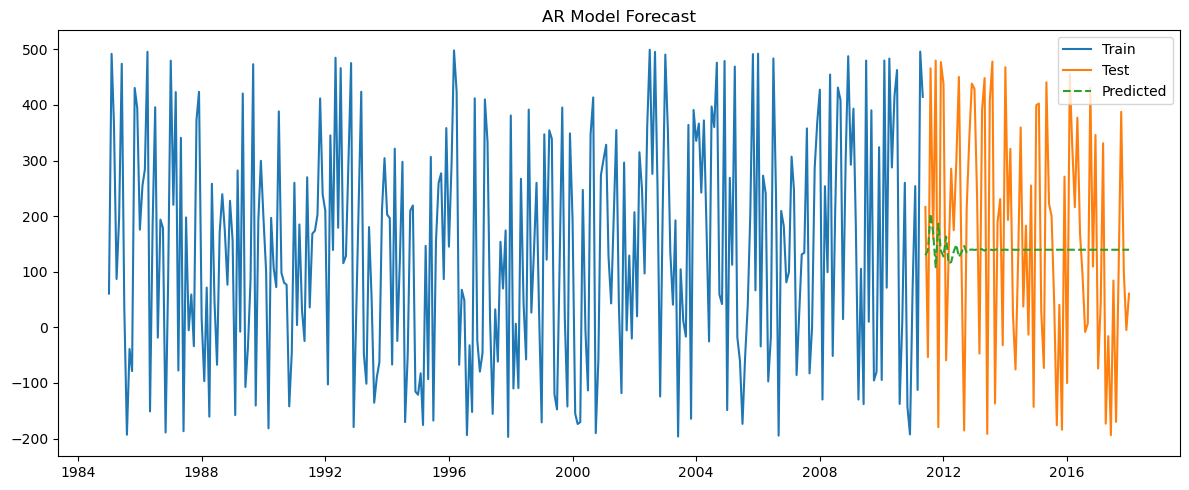

In [34]:
# Forecast plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title('AR Model Forecast')
plt.tight_layout()
plt.show()